In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nbme-score-clinical-patient-notes/sample_submission.csv
/kaggle/input/nbme-score-clinical-patient-notes/patient_notes.csv
/kaggle/input/nbme-score-clinical-patient-notes/features.csv
/kaggle/input/nbme-score-clinical-patient-notes/train.csv
/kaggle/input/nbme-score-clinical-patient-notes/test.csv


In [2]:

!pip install textstat

import numpy as np
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import textstat
import spacy
nlp = spacy.load('en_core_web_sm')

from termcolor import colored
from wordcloud import WordCloud,STOPWORDS
from spacy import displacy
from nltk.tokenize import sent_tokenize, word_tokenize 

import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 101 kB 1.1 MB/s           
     |████████████████████████████████| 2.0 MB 4.1 MB/s            


In [3]:
patient_notes = pd.read_csv('/kaggle/input/nbme-score-clinical-patient-notes/patient_notes.csv')
features = pd.read_csv('/kaggle/input/nbme-score-clinical-patient-notes/features.csv')
train = pd.read_csv('/kaggle/input/nbme-score-clinical-patient-notes/train.csv')

In [4]:
patient_notes.head()

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [5]:
patient_notes['pn_history'][0]

"17-year-old male, has come to the student health clinic complaining of heart pounding. Mr. Cleveland's mother has given verbal consent for a history, physical examination, and treatment\r\n-began 2-3 months ago,sudden,intermittent for 2 days(lasting 3-4 min),worsening,non-allev/aggrav\r\n-associated with dispnea on exersion and rest,stressed out about school\r\n-reports fe feels like his heart is jumping out of his chest\r\n-ros:denies chest pain,dyaphoresis,wt loss,chills,fever,nausea,vomiting,pedal edeam\r\n-pmh:non,meds :aderol (from a friend),nkda\r\n-fh:father had MI recently,mother has thyroid dz\r\n-sh:non-smoker,mariguana 5-6 months ago,3 beers on the weekend, basketball at school\r\n-sh:no std"

In [6]:
features.head()

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


In [7]:
train.head()

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


In [8]:
features.nunique()

feature_num     143
case_num         10
feature_text    131
dtype: int64

In [9]:
patient_notes.nunique()

pn_num        42146
case_num         10
pn_history    42146
dtype: int64

In [10]:
train.nunique()

id             14300
case_num          10
pn_num          1000
feature_num      143
annotation      5201
location        7534
dtype: int64

In [11]:
def patient_data(pn_num):
    subset = train[train['pn_num'] == pn_num]
    
    features_lst = subset['feature_num'].tolist()
    annotations_lst = subset['annotation'].tolist()
    
    subset_c = subset.copy()
    subset_c['location'] = subset_c['location'].apply(eval)
    subset_c['annotation'] = subset_c['annotation'].apply(eval)
    locations  = subset_c["location"]
    annotations = subset_c["annotation"]
    
    print("*"*80)
    print(colored("Patient Number: " + str(pn_num), 'green'))
    patient_history = patient_notes[patient_notes['pn_num']==pn_num]['pn_history'].item()
    
    print(colored("\nAnnotated Patient History", 'green'))
    
    ents = []
    for location in locations:
        for i in range(len(location)):
            for loc in location:
                val = loc.split()
                ents.append({
                'start': int(val[0]), 
                'end' :  int(val[1]),
                'label' : "Annotation"
                })
    ents = sorted(ents, key = lambda i: i['start'])

    doc = {
        'text' : patient_history,
        'ents' : ents
    }
    colors = {"Annotation" :"linear-gradient(to right, #2980b9, #6dd5fa, #ffffff);" } 
    options = {"colors": colors}
    spacy.displacy.render(doc, style='ent', options = options , manual=True, jupyter=True);
    
    print(colored("\nVisualizing NER", 'green'))
    doc = nlp(patient_history)
    displacy.render(doc, style='ent', jupyter = True)
    
    """print(colored("\nVisualizing POS tagging", 'green'))
    sentences = sent_tokenize(patient_history)
    word_count = lambda sentence: len(word_tokenize(sentence))
    pos_text = max(sentences, key=word_count)  
    doc = nlp(pos_text)
    displacy.render(doc, style="dep")"""

    print(colored("\nFeatures", 'green'))
    for feature_num in features_lst:
        feature = features[features['feature_num'] == feature_num]['feature_text'][feature_num]
        print(colored(feature, 'blue'))
        
patient_data(352)
patient_data(46)
patient_data(100)

********************************************************************************
Patient Number: 352

Annotated Patient History



Visualizing NER



Features
Family-history-of-MI-OR-Family-history-of-myocardial-infarction
Family-history-of-thyroid-disorder
Chest-pressure
Intermittent-symptoms
Lightheaded
No-hair-changes-OR-no-nail-changes-OR-no-temperature-intolerance
Adderall-use
Shortness-of-breath
Caffeine-use
heart-pounding-OR-heart-racing
Few-months-duration
17-year
Male
********************************************************************************
Patient Number: 46

Annotated Patient History



Visualizing NER



Features
Family-history-of-MI-OR-Family-history-of-myocardial-infarction
Family-history-of-thyroid-disorder
Chest-pressure
Intermittent-symptoms
Lightheaded
No-hair-changes-OR-no-nail-changes-OR-no-temperature-intolerance
Adderall-use
Shortness-of-breath
Caffeine-use
heart-pounding-OR-heart-racing
Few-months-duration
17-year
Male
********************************************************************************
Patient Number: 100

Annotated Patient History



Visualizing NER



Features
Family-history-of-MI-OR-Family-history-of-myocardial-infarction
Family-history-of-thyroid-disorder
Chest-pressure
Intermittent-symptoms
Lightheaded
No-hair-changes-OR-no-nail-changes-OR-no-temperature-intolerance
Adderall-use
Shortness-of-breath
Caffeine-use
heart-pounding-OR-heart-racing
Few-months-duration
17-year
Male


annotation


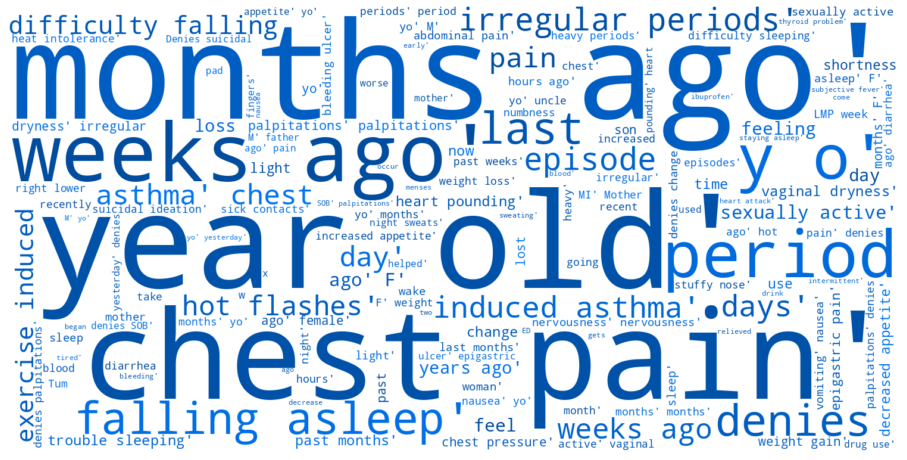

feature_text


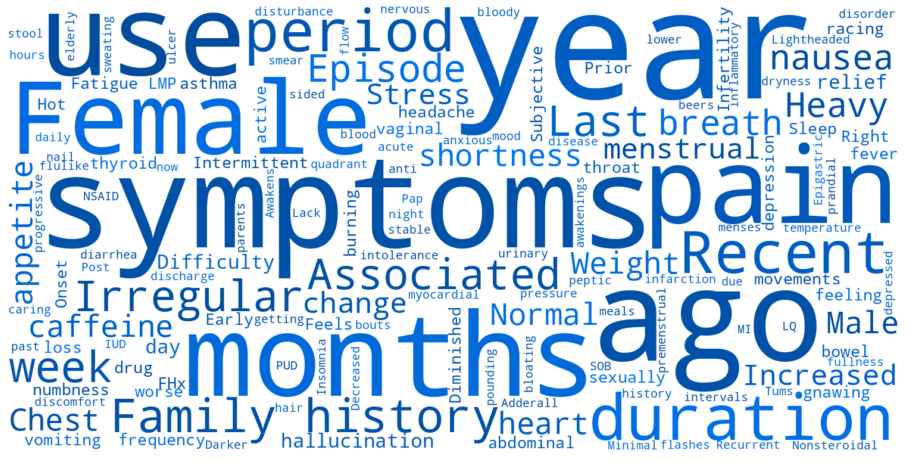

pn_history


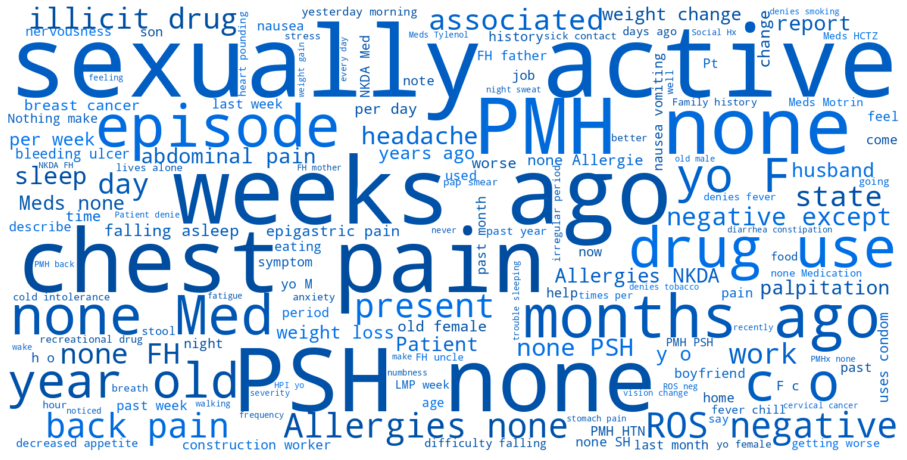

In [12]:
def color_wc(word=None,font_size=None,position=None, orientation=None,font_path=None, random_state=None):
    h = int(360.0 * 150.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(80, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def create_wordcloud(df, col):
    print(colored(col, 'green'))
    plt.subplots(figsize=(16,16))
    wc = WordCloud(stopwords=STOPWORDS,background_color="white", contour_width=2, contour_color='blue',width=1500, height=750,color_func=color_wc,max_words=150, max_font_size=256,random_state=42)
    wc.generate(' '.join(df[col]))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    
create_wordcloud(train, 'annotation')
create_wordcloud(features, 'feature_text')
create_wordcloud(patient_notes, 'pn_history')


In [13]:
def patient_data(pn_num):
    subset = train[train['pn_num'] == pn_num]
    
    features_lst = subset['feature_num'].tolist()
    annotations_lst = subset['annotation'].tolist()
    
    subset_c = subset.copy()
    subset_c['location'] = subset_c['location'].apply(eval)
    subset_c['annotation'] = subset_c['annotation'].apply(eval)
    locations  = subset_c["location"]
    annotations = subset_c["annotation"]
    
    print("*"*80)
    print(colored("Patient Number: " + str(pn_num), 'green'))
    patient_history = patient_notes[patient_notes['pn_num']==pn_num]['pn_history'].item()
    
    for feature_num in features_lst:
        feature = features[features['feature_num'] == feature_num]['feature_text'][feature_num]
        
        print(feature)

In [14]:
patient_data(46)

********************************************************************************
Patient Number: 46
Family-history-of-MI-OR-Family-history-of-myocardial-infarction
Family-history-of-thyroid-disorder
Chest-pressure
Intermittent-symptoms
Lightheaded
No-hair-changes-OR-no-nail-changes-OR-no-temperature-intolerance
Adderall-use
Shortness-of-breath
Caffeine-use
heart-pounding-OR-heart-racing
Few-months-duration
17-year
Male
